In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/Colab\ Notebooks/aml2024-students-copy/Homeworks/HW4/

/content/drive/MyDrive/Colab Notebooks/aml2024-students-copy/Homeworks/HW4


# Regression of car prices from car features
The goal is to come up with a predictive model for prices of cars based on different features of cars. We want to understand the factors on which the pricing of cars depends i.e. what factors affect the pricing of cars. The dataset can be downloaded from:

https://www.kaggle.com/goyalshalini93/car-data

Data consists of both Categorical and Numerical Entries. We will only use the numerical entries for prediction for simplicity. You may (in the future) convert the categorical entries to numerical ones to improve prediction accuracy. The columns are the features of the car, including its price. You will regress the car price from the other features.

Several features of the cars are given in the attached spreadsheet. You will use the nuumerical features to make the prediction. The goal is to obtain good predictions using minimum number of predictors, which will improve interpretability.

In [5]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso
from sklearn.metrics import mean_squared_error

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


### Download the data
1. Drop rows with NAN entries
2. Scale the features
3. Add a constant feature; car prices often has a baseline. This can be omitted for the extra-credit part with mean subtraction


In [6]:
data = pd.read_csv("CarPrice_Assignment.csv")
data.head(10)

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.000
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.000
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.000
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.000
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.000
5,6,2,audi fox,gas,std,two,sedan,fwd,front,99.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,15250.000
6,7,1,audi 100ls,gas,std,four,sedan,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,17710.000
7,8,1,audi 5000,gas,std,four,wagon,fwd,front,105.8,...,136,mpfi,3.19,3.40,8.5,110,5500,19,25,18920.000
8,9,1,audi 4000,gas,turbo,four,sedan,fwd,front,105.8,...,131,mpfi,3.13,3.40,8.3,140,5500,17,20,23875.000
9,10,0,audi 5000s (diesel),gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160,5500,16,22,17859.167


## Preprocessing the data

Remove any NAN entries, extract the target field, and scale the data

In [7]:
# Keep only the numerical fields for convenience. Omit categorical fields
numerics = ['int16','int32','int64','float16','float32','float64']
numerical_vars = list(data.select_dtypes(include=numerics).columns)
data = data[numerical_vars]

# Drop training vectors with NAN entries
data.dropna(axis=0, how='any',inplace=True)

# Extract the target field
y = data['price'].to_numpy()

# Remove the target and ID fields from X
datanew = data.drop(['price'],axis=1)
X = datanew.to_numpy()
# Scale the data to make their variance one
X = scale(X,with_mean='False')

# Add a constant column to the features to account for baseline
n,m = X.shape
X0 = np.ones((n,1))
X = np.hstack((X,X0))

# Verify that sale price is eliminated
print('Size of Pre-processed data',X.shape)
#Display the  dataset after dropping the price
datanew.head(3)

Size of Pre-processed data (205, 16)


<ipython-input-7-3efb53657b15>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(axis=0, how='any',inplace=True)


,car_ID,symboling,wheelbase,carlength,carwidth,carheight,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
0,1,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
1,2,3,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111,5000,21,27
2,3,1,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154,5000,19,26


# Visualizing the data

We will load the variables to the matrix $\mathbf X$ and the prices to the vector $y$. We will seek to express the price vector $y$ as a weighted linear combination of the variables denoted by the columns of $\mathbf X$

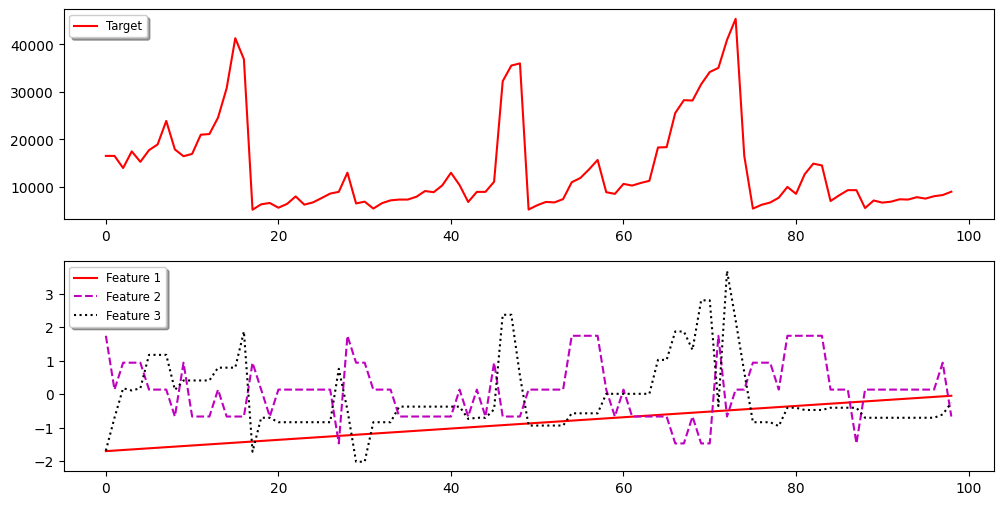

In [8]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
c=ax[0].plot(y[1:100],'r',label='Target')
l = ax[0].legend(loc='upper left', shadow=True, fontsize='small')

c=ax[1].plot(X[1:100,0],'r',label='Feature 1')
c=ax[1].plot(X[1:100,1],'m--',label='Feature 2')
c=ax[1].plot(X[1:100,2],'k:',label='Feature 3')
legend = ax[1].legend(loc='upper left', shadow=True, fontsize='small')




## Split into training and validation datasets

Training dataset size (153,)
Test dataset size (52,)


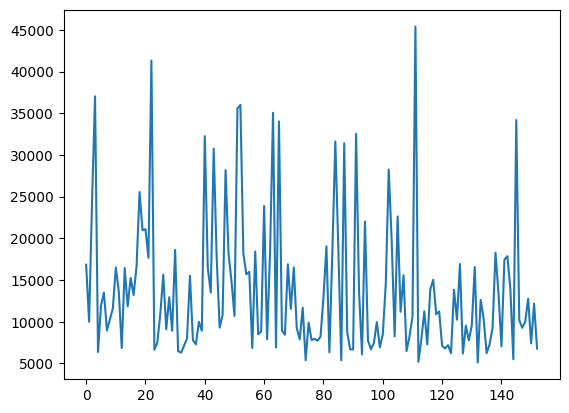

In [9]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.25,random_state=32)
print('Training dataset size',y_train.shape)
print('Test dataset size',y_test.shape)

s=plt.plot(y_train)


## Neural network regression of car-prices

We assume that the car prices (y) can be predicted as

$$y = f(x) $$

where $x = [x_0 .. x_9 ..]$ are the car features and $f$ is a three layer fully connected neural network.
We first create the matrix X_train, whose columns are the normalized training features.

Create a three layer neural network with hidden layers of h1 and h2 neurons respectively. Use RELU activations at the hidden layers and no activation on the output layer

## <font color=red> YOUR CODE BELOW </font>




In [10]:
class Net(nn.Module):
    def __init__(self,Nfeatures,Noutput,Nh1=10,Nh2=10):
        super(Net, self).__init__()
        # YOUR CODE HERE
        self.fc1 = nn.Linear(Nfeatures, Nh1)     # Put input size here
        self.fc2 = nn.Linear(Nh1, Nh2)
        self.fc3 = nn.Linear(Nh2, Noutput)    # Put output size here

    def forward(self, x):
        # YOUR CODE HERE
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x

# Normalize the features and labels

In [11]:
featureScale = np.max(np.abs(X_train),axis=0,keepdims=True)
X_train_T = X_train/featureScale
X_train_T = torch.tensor(X_train_T.astype(np.float32))

ymax = np.max(y_train,axis=0,keepdims=True)
y_train_T = torch.tensor(y_train.astype(np.float32)/ymax).unsqueeze(1)


# Training

## <font color=red> YOUR CODE BELOW </font>



1. Define a network with 20 features/neurons in hidden layer 1 and 25 in layer 2
2. Define optimizer to be SGD
3. Define the loss as the norm of the error
4. Train the network for 10,000 epochs with a learning rate of 1e-3
5. Once it is working, change the learning rate, and the number of features/neurons in the hidden layers


Error = 4.377838778300388


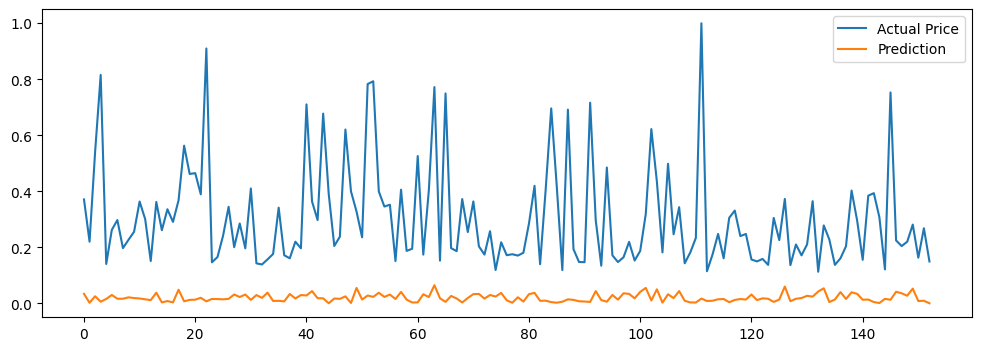

Error = 0.7438096368598475


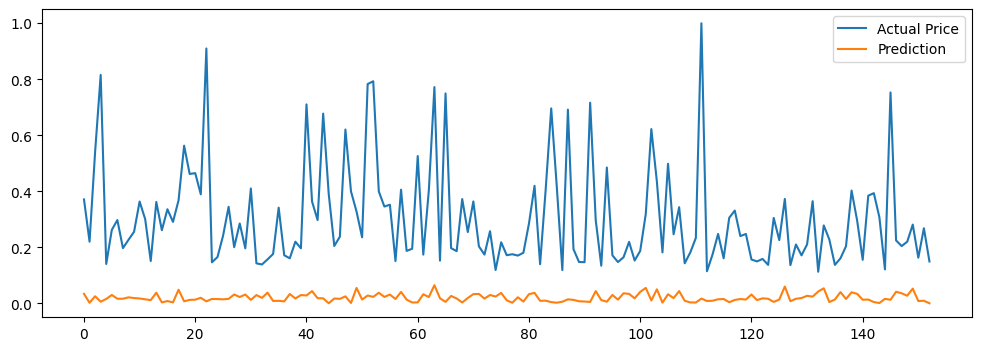

Error = 0.5990054946115342


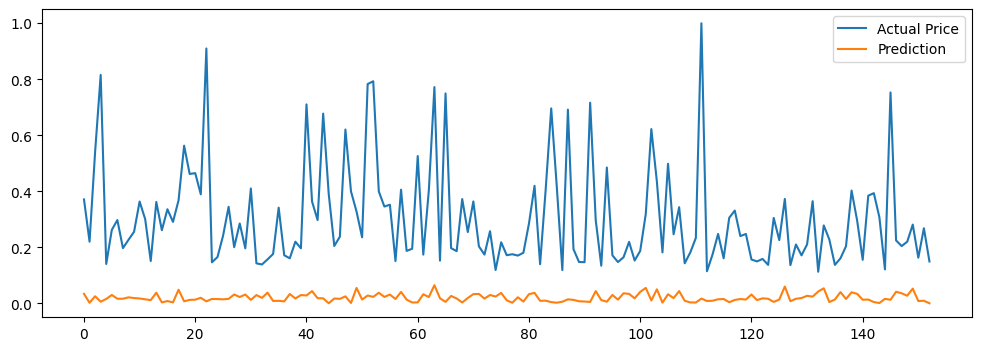

Error = 0.5076729096478119


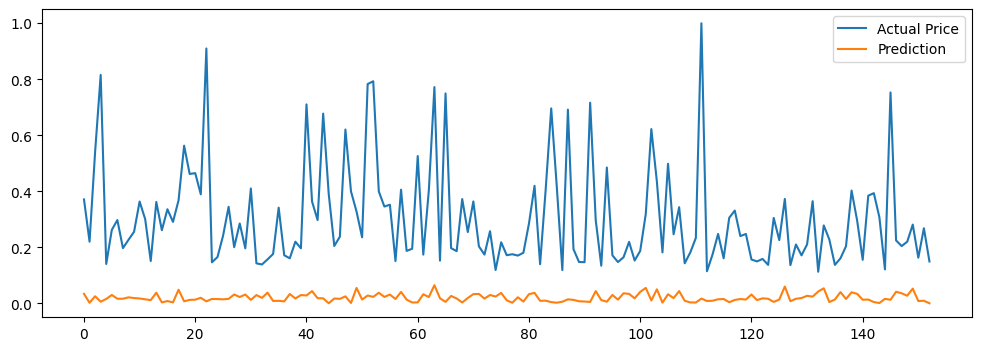

Error = 0.43062887234709735


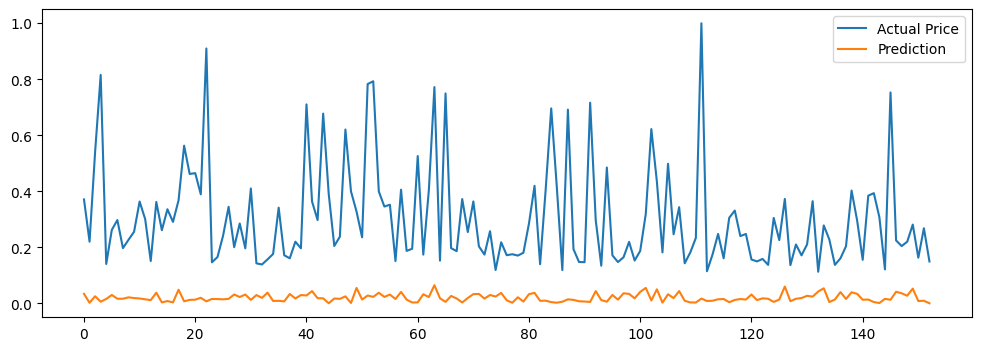

Error = 0.3771845161426958


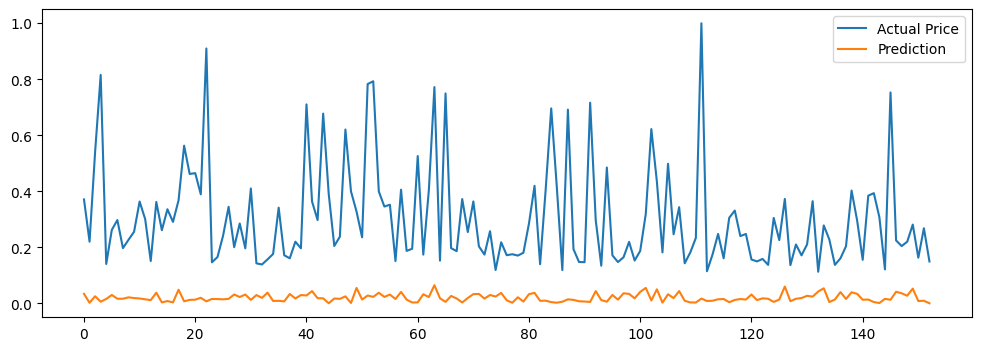

Error = 0.3467710719344595


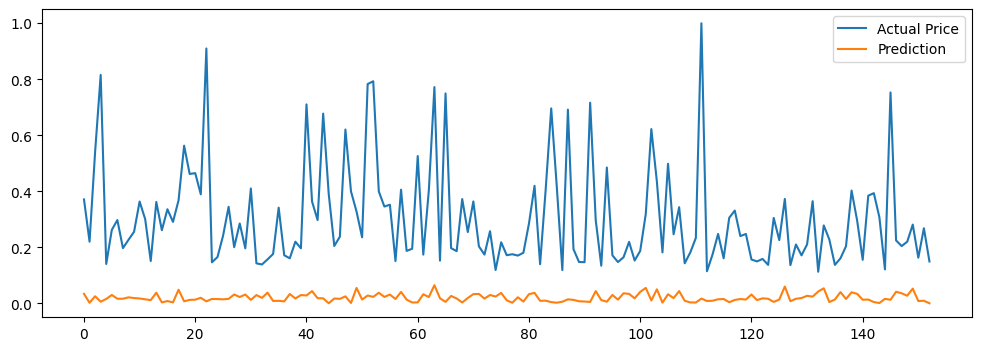

Error = 0.32552465071623926


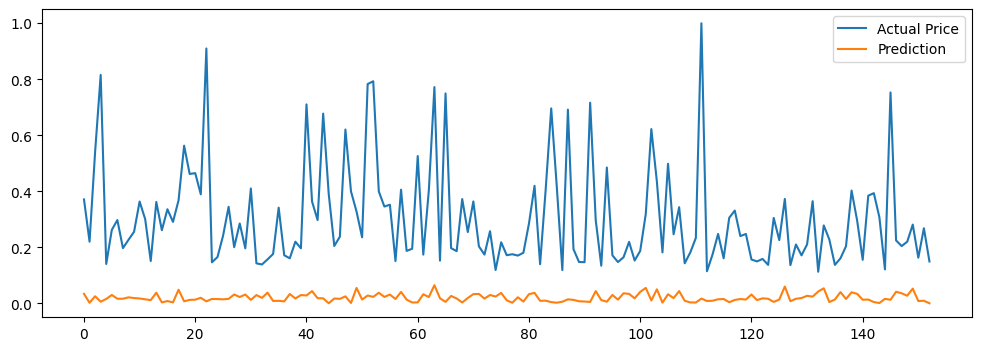

Error = 0.3178009910464723


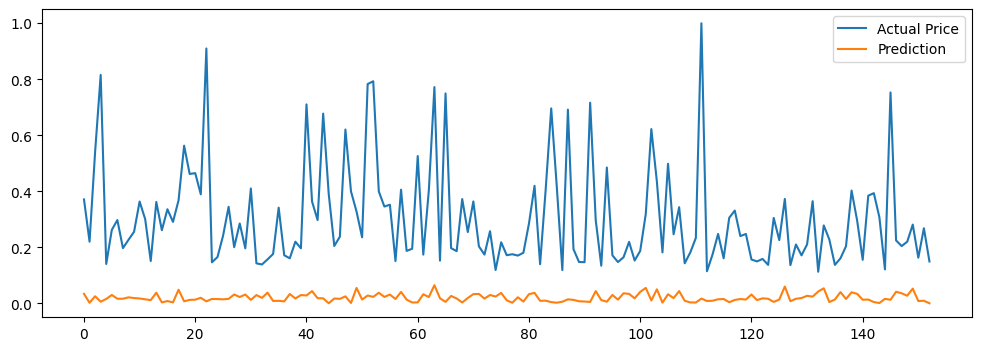

Error = 0.31799011181428133


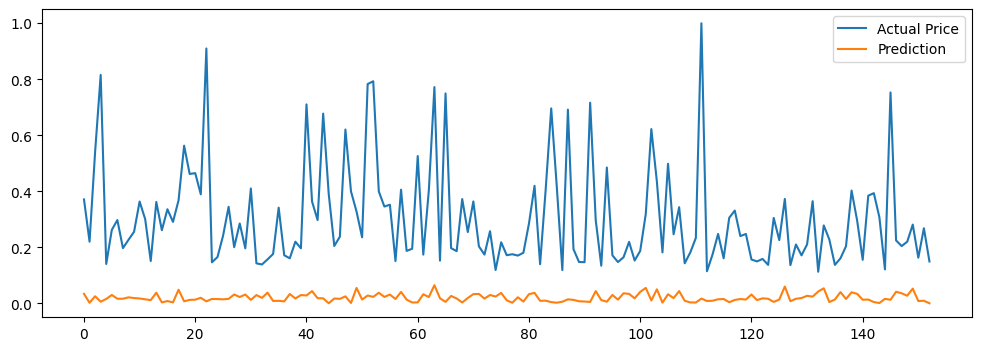

In [13]:
# YOUR CODE HERE
# 1. Define the network w/ 20 features in hidden layer 1 and 25 in layer 2
net = Net(16,1,20,25)
out = net(X_train_T)

# 2. Use SGD as your optimizer, specify the network parameters and learning rate
learning_rate = 0.001
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
# 3. Define loss as norm of the error
loss = nn.MSELoss()

# 4. Train for 10,000 epochs
for epoch in range(10000):
    pred = net(X_train_T)
    loss = torch.norm(pred - y_train_T)

    #Backward pass
    optimizer.zero_grad()
    loss.backward() # computes the gradient
    optimizer.step() # update

    if(np.mod(epoch,1000)==0):
      print("Error =",loss.detach().cpu().item())
      fig,ax = plt.subplots(1,1,figsize=(12,4))
      ax.plot(y_train_T.abs().detach().cpu(),label='Actual Price')
      ax.plot(out.abs().detach().cpu(),label='Prediction')
      ax.legend()
      plt.show()

##  Testing the predictions



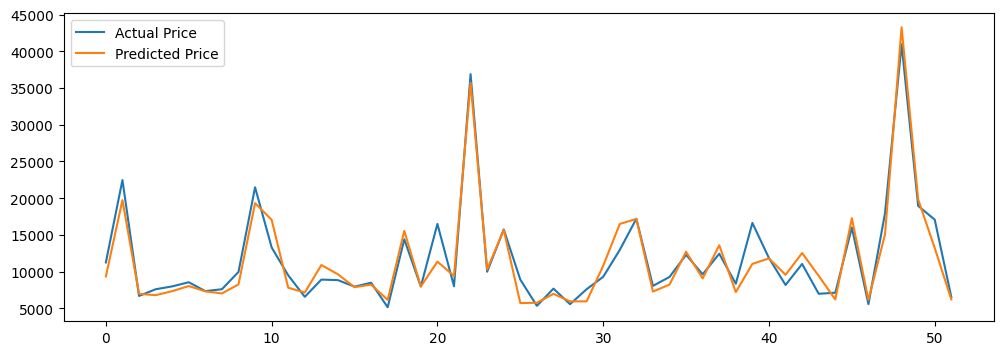

In [14]:
X_test_T = X_test/featureScale
X_test_T = torch.tensor(X_test_T.astype(np.float32))
y_test_T = torch.tensor(y_test.astype(np.float32)).unsqueeze(1)
# MODIFY CODE BELOW

out = net(X_test_T)

fig,ax = plt.subplots(1,1,figsize=(12,4))
s=ax.plot(y_test_T.detach().cpu(),label='Actual Price')
s=ax.plot(out.abs().detach().cpu()*ymax,label='Predicted Price')
s=ax.legend()
